In [1]:
%run auxiliar_functions.py

import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import seaborn as sns
sns.set_theme()

In [2]:
def linear_funtion(x, y_0, D):
    return y_0 + 6 * D * x


Visiting: Data/O-based/d-Bi2O3/AIMD/stoichiometric/500K
['Bi', 'O'] [ 72 108] [1]
Initial point: 3312
Initial point: 5970


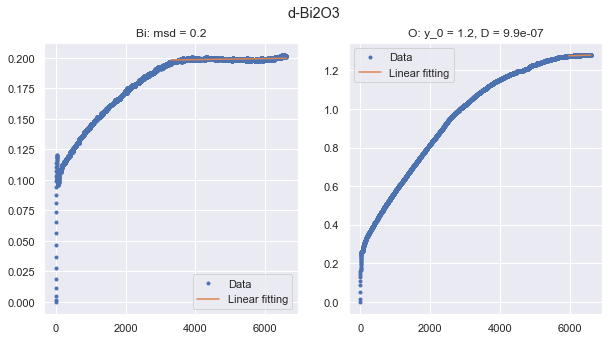

Mean non-diffusive msd: 0.1989171400503291

Created 1 files out of 1


In [3]:
path = 'Data/O-based/d-Bi2O3'

diff_elements = ['Li', 'Na', 'Ag', 'Cu', 'Cl', 'I', 'Br', 'F', 'O']
name_line = 4
concentration_line = 5

proportion = 0.2
created = 0
failed = 0

while True:
    try: # This is not a directory.
        folder_content = listdir(path)
    except NotADirectoryError:
        path, depth, folder_visited = folder_backward(path, depth, folder_visited)
        continue
    
    try: # Fully explored directory.
        new_folder = folder_content[folder_visited[depth]]
        folder_visited[depth] += 1
    except IndexError:
        if depth == 0:
            break
        
        path, depth, folder_visited = folder_backward(path, depth, folder_visited)
        continue
    
    path, depth, folder_visited = folder_forward(path, new_folder, depth, folder_visited)
    
    if new_folder[-1] == 'K':
        try:         
            print(f'\nVisiting: {path}')
            
            # Getting the name of the material
            for i in range(len(path)):
                if (path[i-6:i-1] == 'based'):
                    material = ''
                    j = i
                    while path[j] != '/':
                        material += path[j]
                        j += 1
            
            with open(f'{path}/XDATCAR', 'r') as XDATCAR_file:
                lines = XDATCAR_file.readlines()
            
            components = lines[name_line].split()
            concentrations = np.array(lines[concentration_line].split(), dtype='int')
            N_components = len(components)
            
            # Searching the diffusive element
            for diff_element in diff_elements:
                if diff_element in components:
                    counter = 0
                    for component in components:
                        if (diff_element == component):
                            break
                        counter += 1
                    break
            
            # If the diffusive element is I, Br can also be diffusive
            Diff_position = [counter]
            if (('I' == diff_element) & ('Br' in components)):
                Diff_position.append(counter+1)
                        
            NonDiff_concentrations = np.delete(concentrations, counter)
            NonDiff_atoms = np.sum(NonDiff_concentrations)
            print(components, concentrations, Diff_position)
            
            y_0_array = []
            D_array = []
            mean_NonDiff_msd = 0
            
            rows = int(np.ceil(N_components / 2))
            fig, ax = plt.subplots(rows, 2, figsize=(10, 5*rows))
            
            # Generates the D values for each component.
            for i in range(N_components):
                row = int(i / 2)
                column = int(i % 2)
                
                data = np.loadtxt(f'{path}/msd_{i}.dat')
                
                X = data[:, 0]
                Y = data[:, 1]
                
                pcov_array = []
                
                for k in range(len(X)-2):
                    X_fit = X[k:]
                    Y_fit = Y[k:]
                
                    [y_0, D], pcov = curve_fit(linear_funtion, X_fit, Y_fit)
                    pcov_array.append(pcov[1, 1])
                
                initial_point = np.argmin(pcov_array)
                print(f'Initial point: {initial_point}')
                
                X_fit = X[initial_point:]
                Y_fit = Y[initial_point:]
                
                [y_0, D], pcov = curve_fit(linear_funtion, X_fit, Y_fit)
                
                y_0_array.append(y_0)
                D_array.append(D)
                
                if (N_components == 2):
                    ax[column].plot(X, Y, '.', label=u'Data')
                    ax[column].plot(X_fit, linear_funtion(X_fit, y_0, D), label=u'Linear fitting')

                    # Calculating the mean square displacement for the non diffusive atoms
                    if i not in Diff_position:
                        mean_NonDiff_msd += np.mean(Y_fit) * concentrations[i]
                        ax[column].set_title(f'{components[i]}: msd = {np.mean(Y_fit):.2g}')
                    else:
                        ax[column].set_title(f'{components[i]}: y_0 = {y_0:.2g}, D = {D:.2g}')

                    ax[column].legend(loc='best')
                
                else:
                    ax[row, column].plot(X, Y, '.', label=u'Data')
                    ax[row, column].plot(X_fit, linear_funtion(X_fit, y_0, D), label=u'Linear fitting')

                    # Calculating the mean square displacement for the non diffusive atoms
                    if i not in Diff_position:
                        mean_NonDiff_msd += np.mean(Y_fit) * concentrations[i]
                        ax[row, column].set_title(f'{components[i]}: msd = {np.mean(Y_fit):.2g}')
                    else:
                        ax[row, column].set_title(f'{components[i]}: y_0 = {y_0:.2g}, D = {D:.2g}')

                    ax[row, column].legend(loc='best')
            
            plt.suptitle(material)
            plt.show()
            mean_NonDiff_msd /= NonDiff_atoms
            print(f'Mean non-diffusive msd: {mean_NonDiff_msd}')
            
            write(path, y_0_line, 'y_0:', y_0_array, N_components)
            write(path, D_line, 'D:', D_array, N_components)
            write(path, NonDiff_msd_line, 'Non-diffusive msd: ', mean_NonDiff_msd)
            
            created += 1
        except:
            failed += 1
            print('--- There was a problem ---')
        
        path, depth, folder_visited = folder_backward(path, depth, folder_visited)

print(f'\nCreated {created} files out of {created + failed}')